# Slime Volleyball Agent Training
This notebook implements training for the Slime Volleyball environment using the Cross Entropy Method (CEM).

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime
import cv2
from IPython.display import display, HTML, clear_output
import time
from matplotlib import animation
import gym
import os

# Monkey patch the gym registration function to handle duplicate registrations
original_register = gym.envs.registration.register

def patched_register(id, **kwargs):
    if id in gym.envs.registry.env_specs:
        return
    return original_register(id, **kwargs)

# Apply the patch
gym.envs.registration.register = patched_register

# Now import slimevolleygym
import slimevolleygym

# Create environment
env = gym.make('SlimeVolley-v0')

# Import our training modules
from models.cem_model import CEMAgent
from training.train_cem import train_cem

In [2]:
# Set up device for PyTorch
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using MPS (Apple Silicon GPU)


## Environment Information
The Slime Volleyball environment provides:
- Observation space: 12-dimensional state vector containing:
  - Agent position (x, y) and velocity (vx, vy)
  - Ball position (x, y) and velocity (vx, vy)
  - Opponent position (x, y) and velocity (vx, vy)
- Action space: 3 binary actions [forward, backward, jump]
- Reward: +1 for scoring, -1 for being scored on
- Episode ends when one player scores

In [3]:
# Print environment details
print("Environment Information:")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

# Initialize the CEM agent with correct parameters
agent = CEMAgent(
    state_dim=env.observation_space.shape[0],
    action_dim=3,  # [forward, backward, jump]
    population_size=50,  # Size of the population for CEM
    elite_ratio=0.2,    # Top 20% are elite
    noise_std=0.1,      # Standard deviation of noise
    learning_rate=0.01  # Learning rate for parameter updates
)

print("\nAgent Architecture:")
print(f"Input dimensions: {env.observation_space.shape[0]}")
print(f"Output dimensions: {env.action_space.n}")
print(f"Population size: {agent.population_size}")
print(f"Elite ratio: {agent.elite_ratio}")

Environment Information:
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (12,), float32)
Action Space: MultiBinary(3)
Using device: mps

Agent Architecture:
Input dimensions: 12
Output dimensions: 3
Population size: 50
Elite ratio: 0.2


## Environment Test
Let's test the environment by running a few random actions and displaying the results.

In [4]:
def test_environment(env, num_steps=300):  # 10 seconds at 30 FPS
    frames = []
    total_reward = 0
    state = env.reset()
    
    print("Running environment test...")
    for step in range(num_steps):
        # Random action: one hot vector
        action = np.zeros(3)
        action[np.random.randint(3)] = 1  # Set one action to 1
        
        # Step environment
        state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Render and capture frame
        try:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
        except Exception as e:
            print(f"Warning: Could not render frame: {e}")
            continue
        
        if done:
            print(f"Episode finished after {step} steps with reward {total_reward}")
            state = env.reset()
            total_reward = 0
    
    env.close()
    return frames

# Run test and create animation
try:
    frames = test_environment(env)
    
    if frames:
        # Create animation
        fig = plt.figure(figsize=(10, 6))
        patch = plt.imshow(frames[0])
        plt.axis('off')
        plt.title('Slime Volleyball Environment Test')

        def animate(i):
            patch.set_array(frames[i])
            return [patch]

        anim = animation.FuncAnimation(
            fig, animate, frames=len(frames),
            interval=1000/30,  # 30 FPS
            blit=True
        )

        plt.close()
        display(HTML(anim.to_jshtml()))
    else:
        print("No frames were captured. Please check if XQuartz is running and properly configured.")
except Exception as e:
    print(f"Error during environment test: {e}")
    print("Please make sure XQuartz is running and properly configured.")

Running environment test...
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x90

## Training Configuration
Set up the hyperparameters for training the agent using CEM.

In [5]:
# Training hyperparameters
hyperparameters = {
    'num_episodes': 100,      # Total episodes to train
    'batch_size': 16,         # Episodes per batch
    'elite_frac': 0.2,        # Top fraction of episodes to use for update
    'eval_interval': 10,      # Episodes between evaluations
    'save_interval': 20,      # Episodes between model saves
}

print("Training Configuration:")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

Training Configuration:
num_episodes: 100
batch_size: 16
elite_frac: 0.2
eval_interval: 10
save_interval: 20


## Training Loop
Train the agent using the Cross Entropy Method:
1. Run multiple episodes with the current policy
2. Select the top performing episodes
3. Update the policy using the elite episodes
4. Repeat

Using device: mps
Using device: mps
Starting training with enhanced agent...


Training:   0%|          | 1/300 [02:20<11:39:38, 140.40s/it, mean_reward=-4.85, std=0.36, best=-4.00, noise=0.199]


New best model saved with mean reward: -4.80


Training:   0%|          | 1/300 [03:58<19:49:22, 238.67s/it, mean_reward=-4.85, std=0.36, best=-4.00, noise=0.199]


Training interrupted by user
Model saved to saved_models/cem_volleyball.pt
Training complete!

Final Evaluation:


NameError: name 'evaluate_agent' is not defined

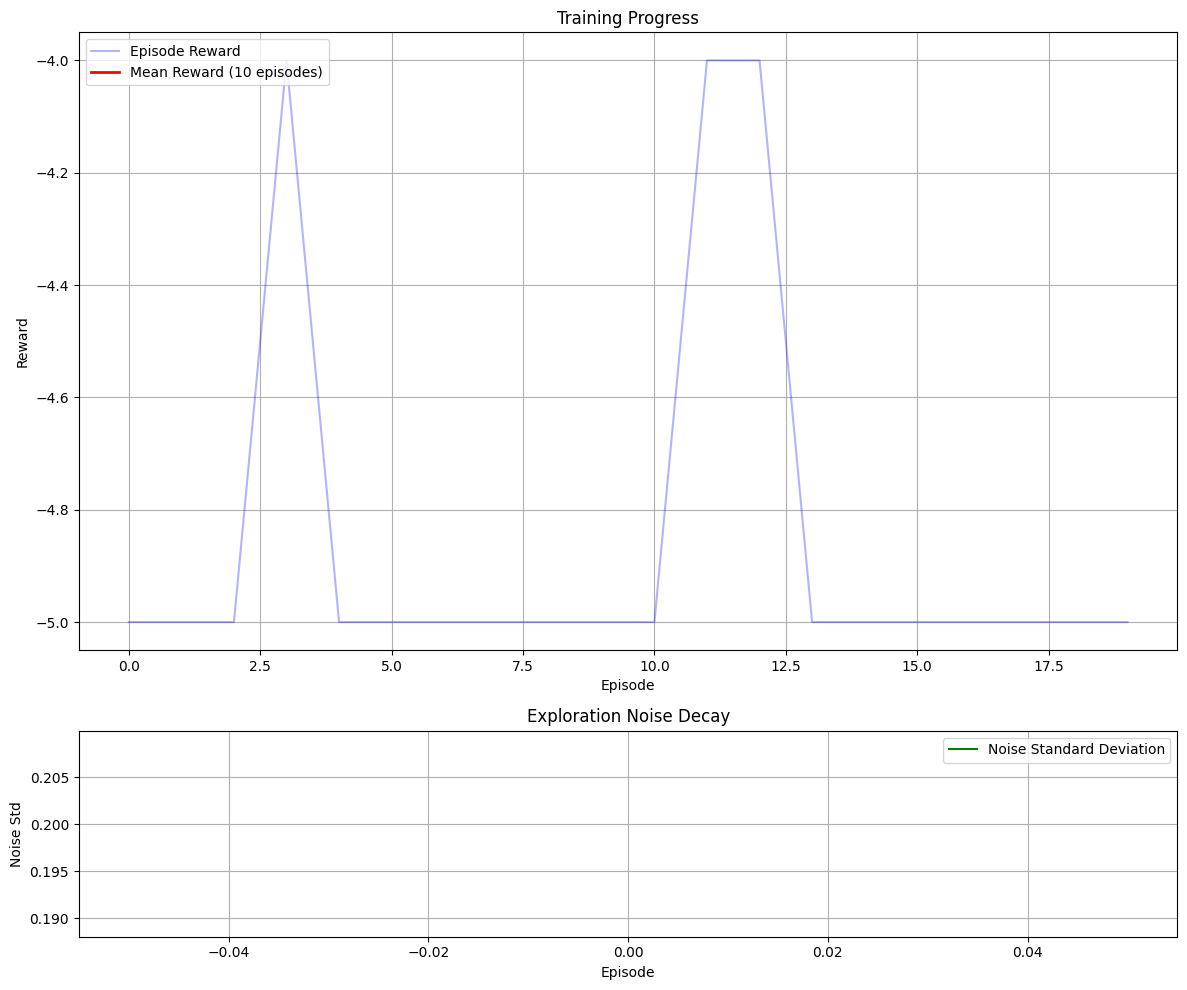

In [6]:
# Create save directory if it doesn't exist
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Make sure device is properly initialized
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Set up improved hyperparameters
improved_hyperparameters = {
    'num_episodes': 300,      # Start with 300 episodes
    'batch_size': 20,         # Increased from 10
    'elite_frac': 0.2,        # Slightly higher
    'eval_interval': 20,      # Evaluate more frequently
    'save_interval': 50,      # Save more frequently
    'reward_shaping': True    # Enable reward shaping
}

# Create a new agent with enhanced representation
state_dim = env.observation_space.shape[0]
action_dim = 3  # SlimeVolley has 3 binary actions: forward, backward, jump

# Recreate the agent with the enhanced model
from models.cem_model import CEMAgent  # Import your old model class

# Create the improved agent
agent = CEMAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    population_size=100,      # Increased from 50
    elite_ratio=0.2,         # Slightly higher
    noise_std=0.2,           # Higher noise for more exploration
    learning_rate=0.05,      # Higher learning rate
    hidden_dim=64,           # New parameter for neural network
    device=str(device)
)

# Close any existing plots to avoid conflicts
plt.close('all')

# Training loop with the improved training function
print("Starting training with enhanced agent...")
metrics = train_cem(
    env=env,
    agent=agent,
    device=device,
    num_episodes=improved_hyperparameters['num_episodes'],
    batch_size=improved_hyperparameters['batch_size'],
    elite_frac=improved_hyperparameters['elite_frac'],
    eval_interval=improved_hyperparameters['eval_interval'],
    save_interval=improved_hyperparameters['save_interval'],
    save_dir=save_dir,
    reward_shaping=improved_hyperparameters['reward_shaping']
)
print("Training complete!")

# Final evaluation
print("\nFinal Evaluation:")
eval_metrics = evaluate_agent(env, agent, num_episodes=20, render=False)
print(f"Final Mean Reward: {eval_metrics['mean_reward']:.2f}")
print(f"Final Std Reward: {eval_metrics['std_reward']:.2f}")
print(f"Min/Max Reward: {eval_metrics['min_reward']:.2f}/{eval_metrics['max_reward']:.2f}")

# Show final summary plot
plt.ioff()
plt.figure(figsize=(12, 8))

# Main plot for rewards
plt.subplot(2, 1, 1)
plt.plot(metrics['episode_rewards'], 'b-', alpha=0.3, label='Episode Reward')
plt.plot(range(0, len(metrics['episode_rewards']), len(metrics['episode_rewards'])//len(metrics['mean_rewards']))[:len(metrics['mean_rewards'])], 
         metrics['mean_rewards'], 'r-', linewidth=2, label='Mean Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress - Complete Run')
plt.legend()
plt.grid(True)

# Plot for noise decay
plt.subplot(2, 1, 2)
plt.plot(metrics['noise_std'], 'g-', label='Exploration Noise')
plt.xlabel('Batch')
plt.ylabel('Noise Std')
plt.title('Exploration Noise Decay')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_progress_final.png')
plt.show()

# Print final statistics
print(f"Training Duration: {metrics['training_duration']:.2f} seconds")
print(f"Final Mean Reward (last 10 episodes): {metrics['mean_rewards'][-1]:.2f}")
print(f"Best Reward: {metrics['best_reward']:.2f}")

## Training Visualization
Plot the training progress and metrics.

In [ ]:
# Plot training metrics
plt.figure(figsize=(15, 5))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(metrics['episode_rewards'], 'b-', alpha=0.3, label='Episode Reward')
plt.plot(metrics['mean_rewards'], 'r-', label='Moving Average')
plt.fill_between(
    range(len(metrics['mean_rewards'])),
    np.array(metrics['mean_rewards']) - np.array(metrics['std_rewards']),
    np.array(metrics['mean_rewards']) + np.array(metrics['std_rewards']),
    alpha=0.2, color='r'
)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.grid(True)
plt.legend()

# Plot win rate
plt.subplot(1, 2, 2)
window = 10
wins = [r > 0 for r in metrics['episode_rewards']]
win_rate = [sum(wins[max(0, i-window):i])/min(i, window) 
            for i in range(1, len(wins)+1)]
plt.plot(win_rate, 'g-', label='Win Rate')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Win Rate (Moving Average, Window={window})')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Save Results
Save the training metrics and configuration for later analysis.

In [ ]:
# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results = {
    'metrics': metrics,
    'hyperparameters': hyperparameters,
    'final_mean_reward': float(np.mean(metrics['episode_rewards'][-10:])),
    'best_reward': float(max(metrics['episode_rewards'])),
    'final_win_rate': win_rate[-1],
    'training_duration': metrics.get('training_duration', 0)
}

# Save to file
results_file = f'results/training_results_{timestamp}.json'
os.makedirs('results', exist_ok=True)
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {results_file}")

# Print summary
print("\nTraining Summary:")
print(f"Final average reward (last 10 episodes): {results['final_mean_reward']:.2f}")
print(f"Best episode reward: {results['best_reward']:.2f}")
print(f"Final win rate: {results['final_win_rate']:.2%}")
print(f"Training duration: {results['training_duration']:.2f} seconds")